In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.gridspec import GridSpec

from mtj.calc_Heff import calc_Heff
from mtj.calc_Hth import compute_thermal_field
from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY

### Demonstration of Magnetization Computation

This notebook utilize some core components of our mtj Python library to compute the magnetization of a magnetic sample. In this demonstration, we perform the simulations on a thin film of soft magnetic material (Permalloy), with $m_S\approx1 \space \text{T}$, and a demagnetization tensor with $N_{xx}=N_{yy} = 0$ and $N_{zz}=1$.

**Physical Constants Used**

| Constant | Symbol | Value | Unit | Description |
|----------|--------|-------|------|-------------|
| Saturation magnetization (Permalloy) | $m_S$ | $\approx 1$ | T | Typical for Permalloy |
| Magnetocrystalline anisotropy constant | $K_u$ | $5 \cdot 10^5$ | J/m³ | Example value for perpendicular anisotropy |
| Temperature | $T$ | 300 | K | Room temperature |
| Volume (approx.) | $V$ | $2000$, $300$, $80$ | nm³ | Magnetic sample volume |
| Time step | $\Delta t$ | $10^{-13}$ to $10^{-10}$ | s | Simulation time step |
| Damping factor | $\alpha$ | 0.008 | (unitless) | Gilbert damping parameter |

In [2]:
def calculate_magnetization(
    m0: npt.NDArray[
        np.float64
    ],  # Initial magnetization (is normalized before simulation)
    H_app: npt.NDArray[np.float64],
    Tn=1e-10,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0.008,  # Damping factor (arbitrarily chosen in this demo)
    K_u=0,  # Crystal anisotropy constant, default: 0
    m_s=1 / VACUUM_PERMEABILITY,  # Default: NiFe permalloy Ms (A/m)
    u_k=np.zeros(3, dtype=np.float64),  # Not used when K_0 = 0
    N=np.diag([0, 0, 1]),  # Default: "infinite" thin film
    T=0,  # Temperature (K) - H_th diabled if 0
    V=1e-9 * 25e-9**2 * np.pi,  # Volume
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))

    # Default:  zero thermal field
    H_th = np.zeros(3, dtype=np.float64)

    for i, t in enumerate(time_series[:-1]):
        # Calculate the effective field
        H_eff = calc_Heff(
            m[i],
            K_u,
            m_s,
            u_k,
            np.zeros(3, dtype=np.float64),  # No STT
            0,  # No STT
            0,  # No STT
            V=0,  # No STT
            H_app=H_app,
            N=N,
            stt_enable=False,  # No STT
        )

        # Compute the thermal field if applicable
        if T > 0:
            H_th = compute_thermal_field(alpha, T, m_s, V, dt)

        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(m[i], H_eff, H_th, dt, alpha)

    return m, time_series

In [3]:
timeFormatter = EngFormatter(unit="s")

We start without thermal fluctuations or STT, finding the equilibrium state when we set $K_u=0$ for a couple of different initial magnetizations. We observe that the equilibrium state is when the magnetization lies in the xy-plane.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_37433/852786096.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


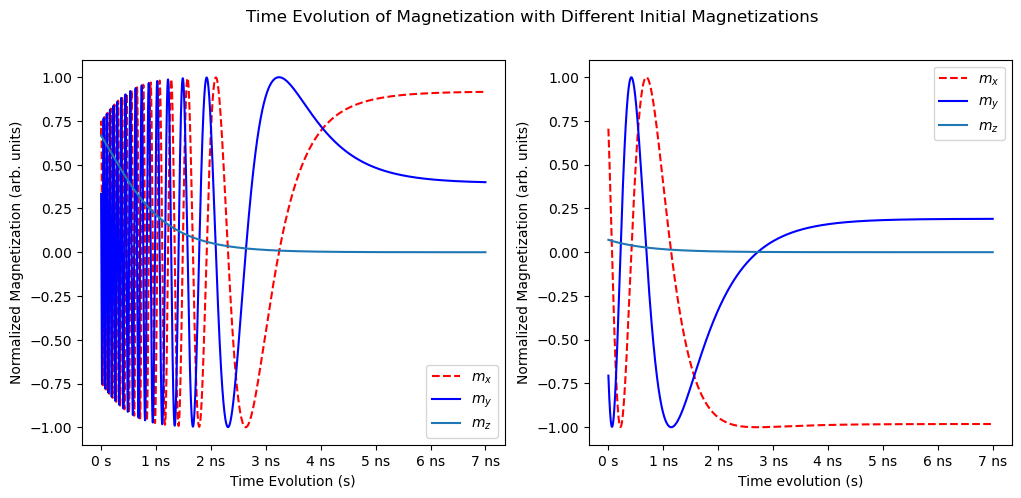

In [4]:
# equilibrium state in zero applied field
m1, t1 = calculate_magnetization(m0=np.array([1, 0.5, 1]), H_app=np.zeros(3), Tn=7e-9)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(t1, m1[:, 0], "r--", label=r"$m_x$")
ax[0].plot(t1, m1[:, 1], "b", label=r"$m_y$")
ax[0].plot(t1, m1[:, 2], label=r"$m_z$")

ax[0].set_xlabel("Time Evolution (s)")
ax[0].set_ylabel("Normalized Magnetization (arb. units)")
ax[0].xaxis.set_major_formatter(timeFormatter)
ax[0].legend()

m2, t2 = calculate_magnetization(m0=np.array([1, -1, 0.1]), H_app=np.zeros(3), Tn=7e-9)

ax[1].plot(t2, m2[:, 0], "r--", label=r"$m_x$")
ax[1].plot(t2, m2[:, 1], "b", label=r"$m_y$")
ax[1].plot(t2, m2[:, 2], label=r"$m_z$")

ax[1].xaxis.set_major_formatter(timeFormatter)
ax[1].set_xlabel("Time evolution (s)")
ax[1].set_ylabel("Normalized Magnetization (arb. units)")
ax[1].legend()
fig.suptitle("Time Evolution of Magnetization with Different Initial Magnetizations")

fig.show()

Simulates and visualizes two magnetization trajectories under zero applied magnetic field, using different initial magnetization vectors. Each trajectory is plotted on a 3D unit sphere to show how the magnetization evolves over time.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_37433/1109848712.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


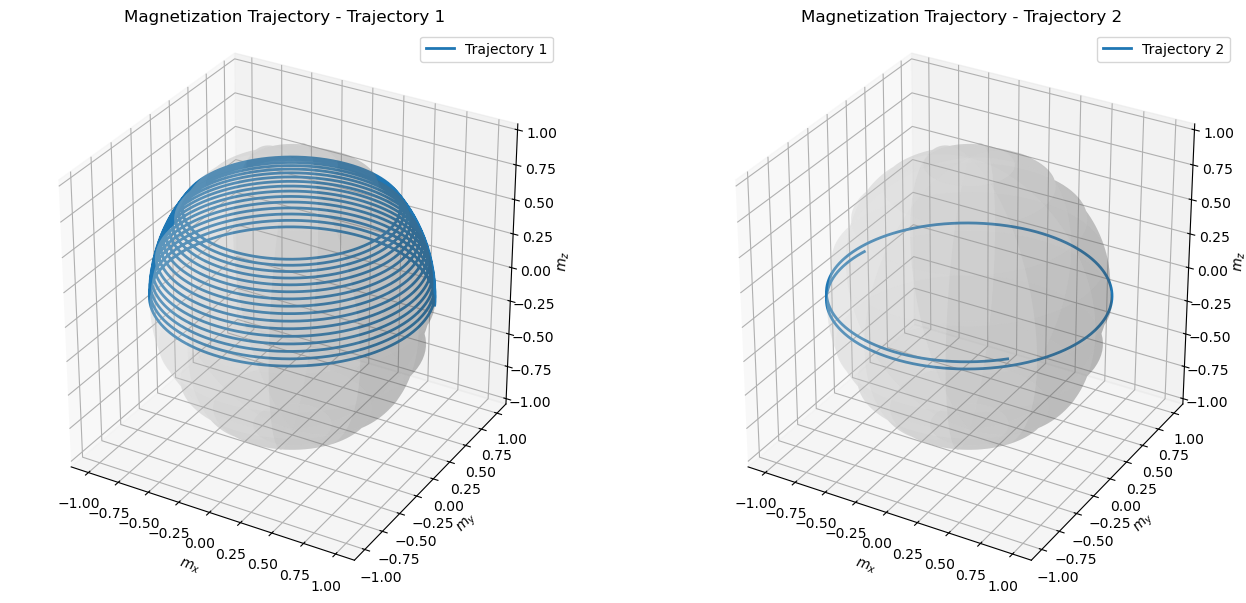

In [5]:
def plot_unit_sphere(ax, m, label):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color='lightgray', alpha=0.2, rstride=10, cstride=10)
    ax.plot(m[:, 0], m[:, 1], m[:, 2], label=label, lw=2)

    ax.set_xlabel(r"$m_x$")
    ax.set_ylabel(r"$m_y$")
    ax.set_zlabel(r"$m_z$")
    ax.set_title(f"Magnetization Trajectory - {label}")
    ax.set_box_aspect([1, 1, 1])
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})
plot_unit_sphere(ax[0], m1, "Trajectory 1")
plot_unit_sphere(ax[1], m2, "Trajectory 2")

fig.tight_layout()
fig.show()


We apply an external field $H_{app}=10^5 \text{ A/m}$ and $H_{app}=10^6 \text{ A/m}$

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_37433/1473524427.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


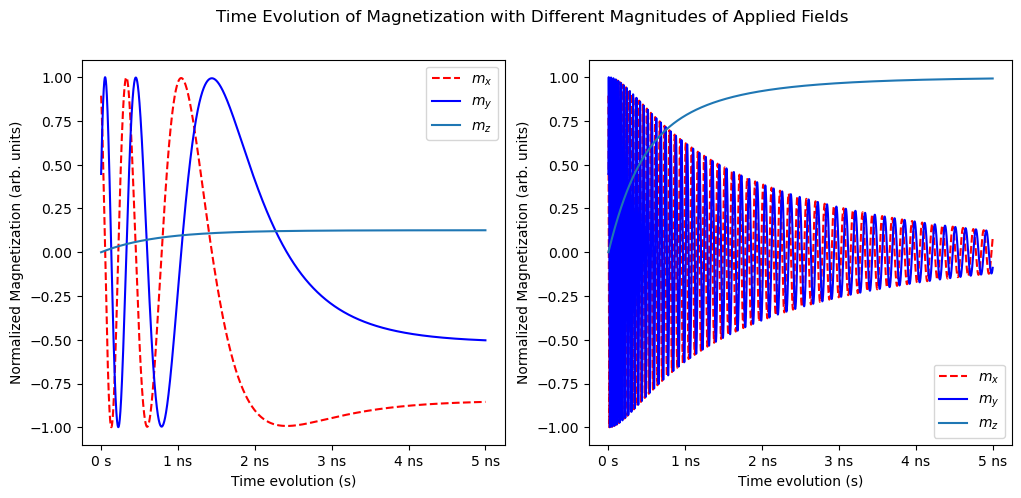

In [6]:
# equilibrium state with applied field
m1, t1 = calculate_magnetization(
    Tn=5e-9, m0=np.array([1, 0.5, 0]), H_app=np.array([0, 0, 1e5])
)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(t1, m1[:, 0], "r--", label=r"$m_x$")
ax[0].plot(t1, m1[:, 1], "b", label=r"$m_y$")
ax[0].plot(t1, m1[:, 2], label=r"$m_z$")

ax[0].legend()
ax[0].set_xlabel("Time evolution (s)")
ax[0].set_ylabel("Normalized Magnetization (arb. units)")
ax[0].xaxis.set_major_formatter(timeFormatter)

m2, t2 = calculate_magnetization(
    Tn=5e-9, m0=np.array([1, 0.5, 0]), H_app=np.array([0, 0, 1e6])
)

ax[1].plot(t2, m2[:, 0], "r--", label=r"$m_x$")
ax[1].plot(t2, m2[:, 1], "b", label=r"$m_y$")
ax[1].plot(t2, m2[:, 2], label=r"$m_z$")

ax[1].legend()
ax[1].set_xlabel("Time evolution (s)")
ax[1].set_ylabel("Normalized Magnetization (arb. units)")
ax[1].xaxis.set_major_formatter(timeFormatter)
fig.suptitle(
    "Time Evolution of Magnetization with Different Magnitudes of Applied Fields"
)
fig.show()

Compares the effect of two different applied magnetic field strengths on magnetization dynamics. The trajectories are plotted on unit spheres to observe precessional behavior with increased field intensity.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_37433/240363941.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


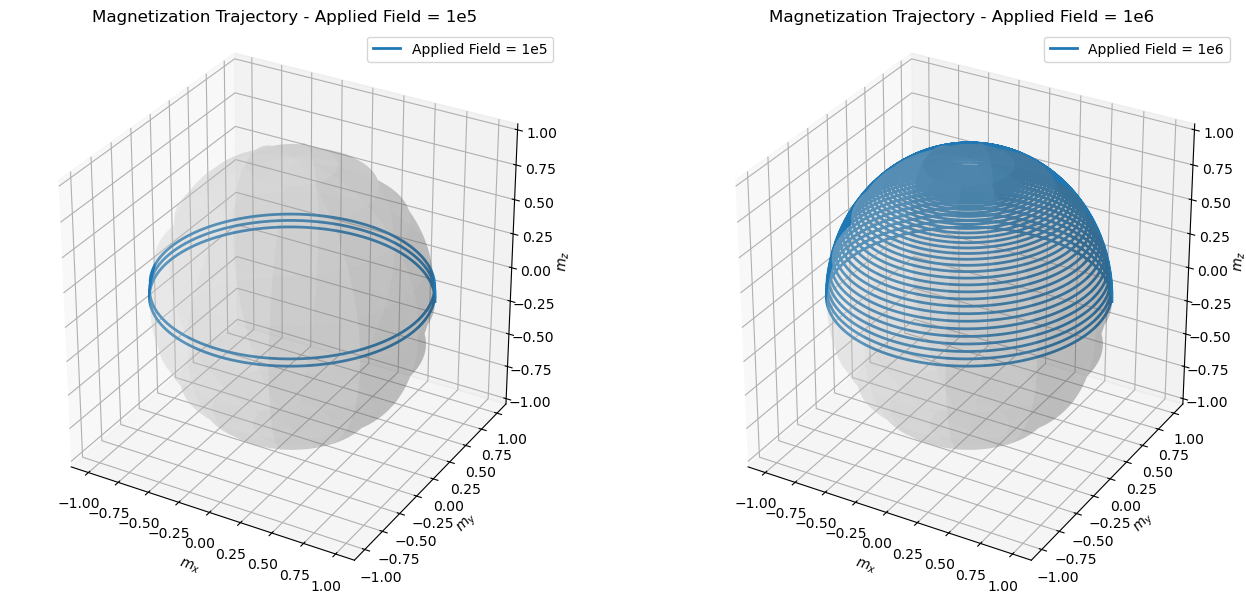

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": "3d"})
plot_unit_sphere(ax[0], m1, "Applied Field = 1e5")
plot_unit_sphere(ax[1], m2, "Applied Field = 1e6")

fig.tight_layout()
fig.show()

Introducing perpendicular magnetocrystalline anisotropy, with anosotropy constant $K_u=5\cdot10^5 \text{ J/m}^3$ based on orders on magnitude found on [Wikipedia](https://en.wikipedia.org/wiki/Magnetocrystalline_anisotropy), we observe that the magnetization aligns perpendiculary without an applied field.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_37433/4258316437.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


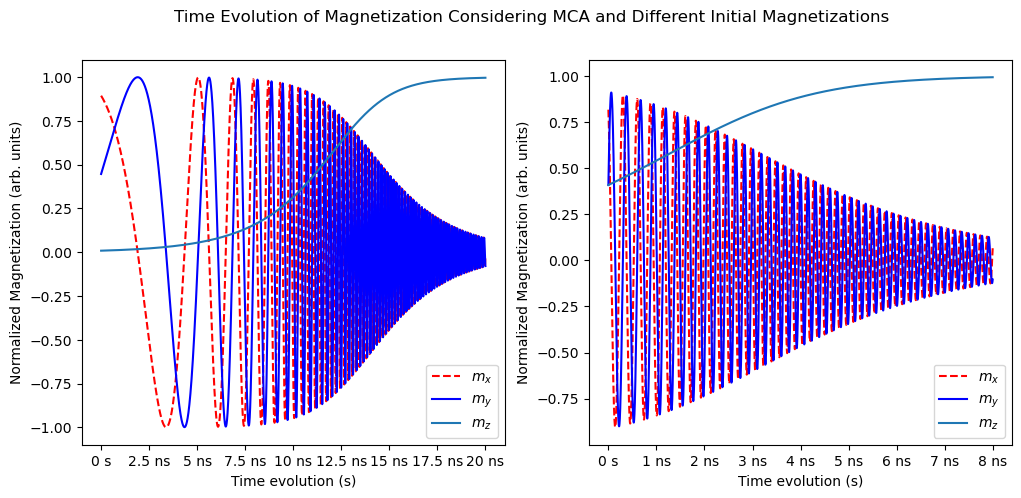

In [8]:
# perpendicular magnetocrystalline anisotropy - equilibrium state in zero applied field
m1, t1 = calculate_magnetization(
    Tn=20e-9,
    m0=np.array([1, 0.5, 0.01]),
    K_u=5e5,
    u_k=np.array([0, 0, 1]),
    H_app=np.zeros(3),
)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(t1, m1[:, 0], "r--", label=r"$m_x$")
ax[0].plot(t1, m1[:, 1], "b", label=r"$m_y$")
ax[0].plot(t1, m1[:, 2], label=r"$m_z$")

ax[0].legend()
ax[0].set_xlabel("Time evolution (s)")
ax[0].set_ylabel("Normalized Magnetization (arb. units)")
ax[0].xaxis.set_major_formatter(timeFormatter)

m2, t2 = calculate_magnetization(
    Tn=8e-9,
    m0=np.array([1, 0.5, 0.5]),
    K_u=5e5,
    u_k=np.array([0, 0, 1]),
    H_app=np.zeros(3),
)

ax[1].plot(t2, m2[:, 0], "r--", label=r"$m_x$")
ax[1].plot(t2, m2[:, 1], "b", label=r"$m_y$")
ax[1].plot(t2, m2[:, 2], label=r"$m_z$")

ax[1].legend()
ax[1].set_xlabel("Time evolution (s)")
ax[1].set_ylabel("Normalized Magnetization (arb. units)")
ax[1].xaxis.set_major_formatter(timeFormatter)

fig.suptitle("Time Evolution of Magnetization Considering MCA and Different Initial Magnetizations")
fig.show()

Simulates magnetization trajectories with uniaxial anisotropy, starting from two different initial magnetizations in 3D sphere. Useful for observing how anisotropy and initial conditions influence magnetization dynamics.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_37433/4279667211.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


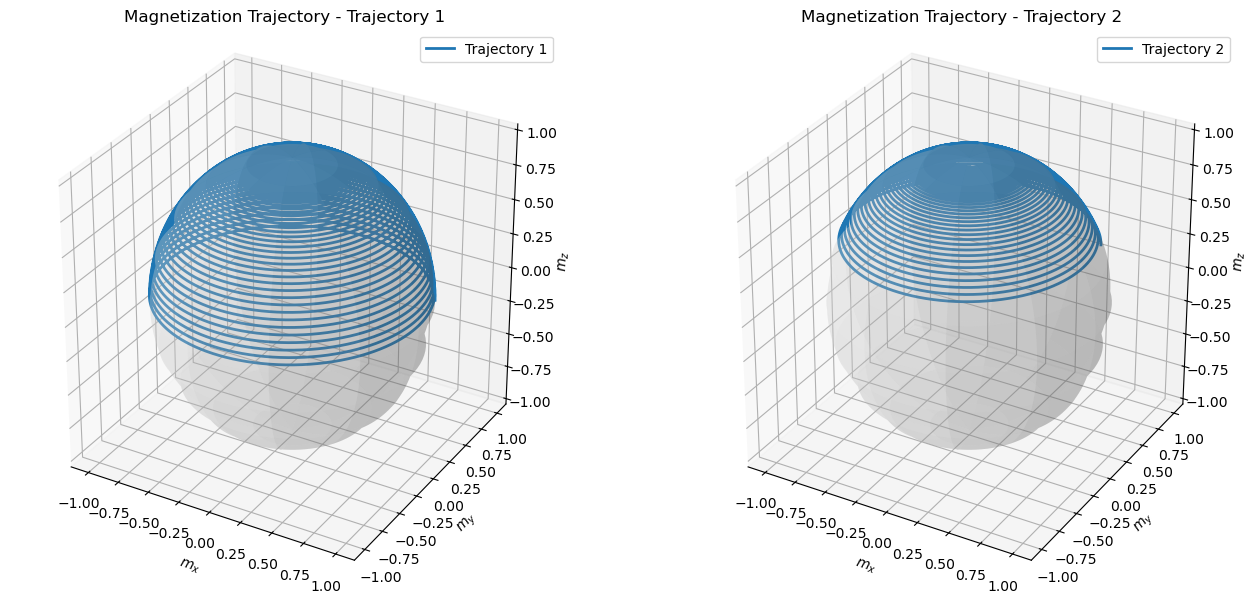

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={"projection": "3d"})
plot_unit_sphere(ax[0], m1, "Trajectory 1")
plot_unit_sphere(ax[1], m2, "Trajectory 2")

fig.tight_layout()
fig.show()

Varying the timestep, we observe that the solution becomes unstable when going above 50 ps.

Text(0, 0.5, 'Normalized Magnetization (arb. units)')

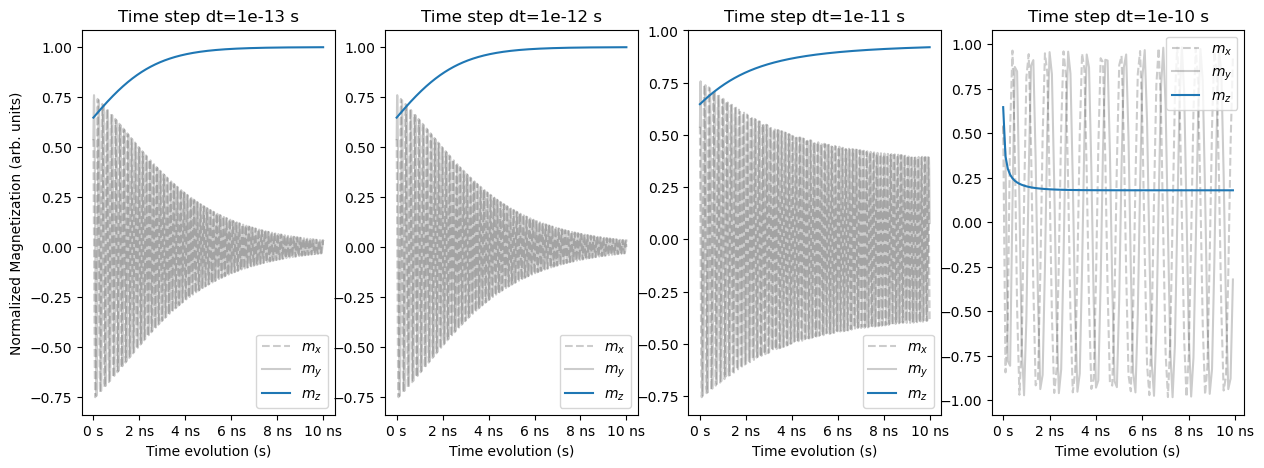

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))

for i, dt in enumerate(np.geomspace(1e-13, 1e-10, 4)):
    m, t = calculate_magnetization(
        Tn=10e-9,
        dt=dt,
        m0=np.array([0.5, 0.5, 0.6]),
        K_u=5e5,
        u_k=np.array([0, 0, 1]),
        H_app=np.zeros(3),
    )

    ax[i].plot(t, m[:, 0], "k--", label=r"$m_x$", alpha=0.2)
    ax[i].plot(t, m[:, 1], "k", label=r"$m_y$", alpha=0.2)
    ax[i].plot(t, m[:, 2], label=r"$m_z$")
    ax[i].set_title(f"Time step dt={dt:.2g} s")

    ax[i].legend()
    ax[i].set_xlabel("Time evolution (s)")
    ax[i].xaxis.set_major_formatter(timeFormatter)

ax[0].set_ylabel("Normalized Magnetization (arb. units)")

Adding thermal fluctuations to the mix, we observe that the paramagnetic regieme, with the constants we have used, is present for a magnetic sample with $V \leq 80 \text{ nm}^3$.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_37433/3243168383.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


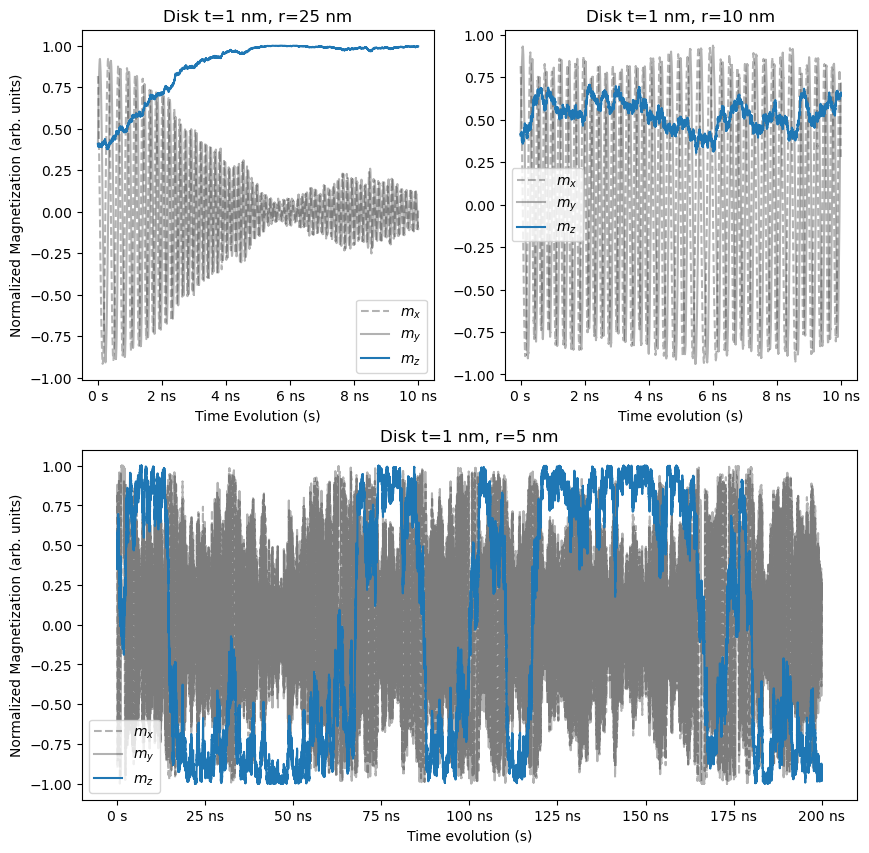

In [11]:
# Thermal field - when do we reach paramagnetic regieme?
m1, t1 = calculate_magnetization(
    Tn=10e-9,
    dt=1e-12,
    m0=np.array([1, 0.5, 0.5]),
    H_app=np.zeros(3),
    K_u=5e5,
    u_k=np.array([0, 0, 1]),
    T=300,
)

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, figure=fig)
ax = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, :]),
]
ax[0].plot(t1, m1[:, 0], "k--", label=r"$m_x$", alpha=0.3)
ax[0].plot(t1, m1[:, 1], "k", label=r"$m_y$", alpha=0.3)
ax[0].plot(t1, m1[:, 2], label=r"$m_z$")

ax[0].legend()
ax[0].set_xlabel("Time Evolution (s)")
ax[0].set_ylabel("Normalized Magnetization (arb. units)")
ax[0].xaxis.set_major_formatter(timeFormatter)
ax[0].set_title(r"Disk t=1 nm, r=25 nm")

m1, t2 = calculate_magnetization(
    Tn=10e-9,
    dt=1e-12,
    m0=np.array([1, 0.5, 0.5]),
    H_app=np.zeros(3),
    K_u=5e5,
    u_k=np.array([0, 0, 1]),
    T=300,
    V=1e-9 * 10e-9**2 * np.pi,
)

ax[1].plot(t2, m1[:, 0], "k--", label=r"$m_x$", alpha=0.3)
ax[1].plot(t2, m1[:, 1], "k", label=r"$m_y$", alpha=0.3)
ax[1].plot(t2, m1[:, 2], label=r"$m_z$")

ax[1].legend()
ax[1].set_xlabel("Time evolution (s)")
ax[1].xaxis.set_major_formatter(timeFormatter)
ax[1].set_title(r"Disk t=1 nm, r=10 nm")

m3, t3 = calculate_magnetization(
    Tn=200e-9,
    dt=1e-12,
    m0=np.array([1, 0.5, 0.5]),
    H_app=np.zeros(3),
    K_u=5e5,
    u_k=np.array([0, 0, 1]),
    T=300,
    V=1e-9 * 5e-9**2 * np.pi,
)

ax[2].plot(t3, m3[:, 0], "k--", label=r"$m_x$", alpha=0.3)
ax[2].plot(t3, m3[:, 1], "k", label=r"$m_y$", alpha=0.3)
ax[2].plot(t3, m3[:, 2], label=r"$m_z$")

ax[2].legend()
ax[2].set_xlabel("Time evolution (s)")
ax[2].set_ylabel("Normalized Magnetization (arb. units)")
ax[2].xaxis.set_major_formatter(timeFormatter)
ax[2].set_title(r"Disk t=1 nm, r=5 nm")

fig.show()

Plots magnetization trajectories for three nanodisks of varying radii but identical thickness in 3D sphere. Demonstrates how thermal fluctuations increasingly affect smaller volumes, leading to more stochastic magnetization behavior.

/var/folders/6g/lh1pblvx51zgy2yzn03xbj880000gn/T/ipykernel_37433/108624828.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


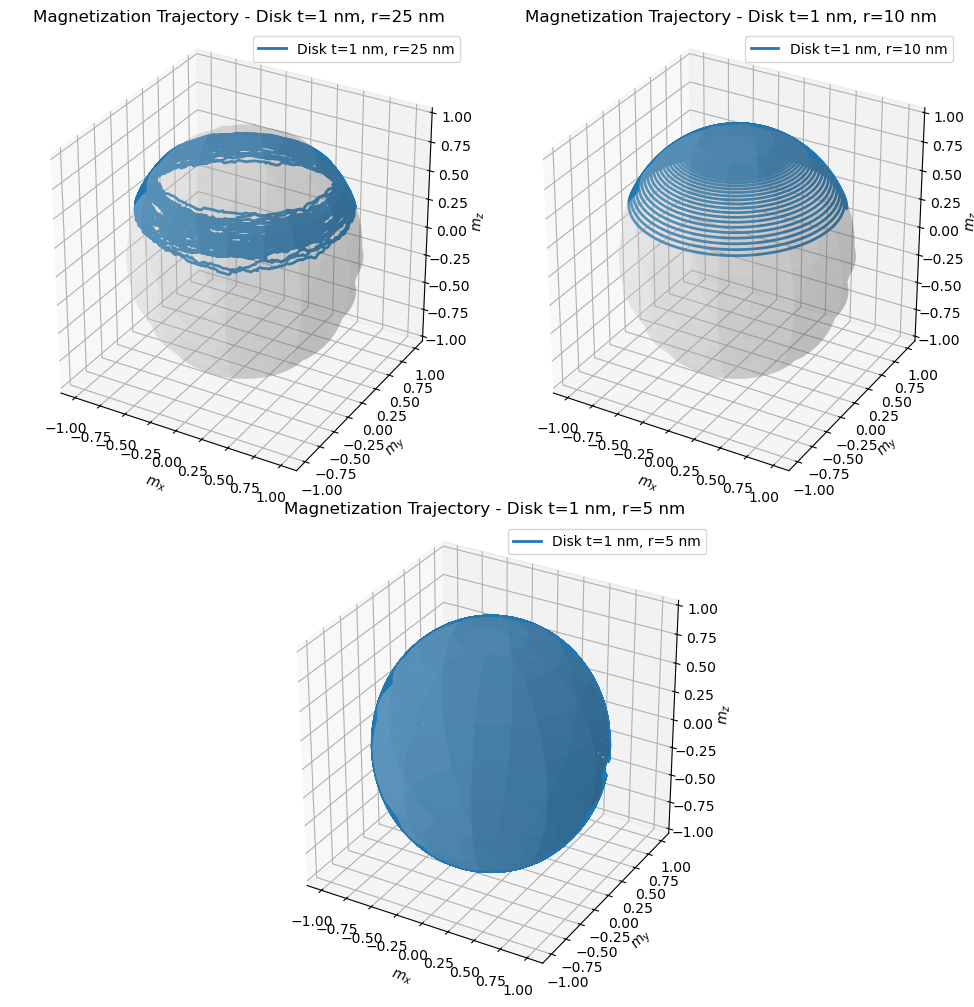

In [12]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2, figure=fig)
ax = [
    fig.add_subplot(gs[0, 0], projection="3d"),
    fig.add_subplot(gs[0, 1], projection="3d"),
    fig.add_subplot(gs[1, :], projection="3d"),
]

plot_unit_sphere(ax[0], m1, r"Disk t=1 nm, r=25 nm")
plot_unit_sphere(ax[1], m2, r"Disk t=1 nm, r=10 nm")
plot_unit_sphere(ax[2], m3, r"Disk t=1 nm, r=5 nm")

fig.tight_layout()
fig.show()